# SDSS-V Plate RVs
This notebook is designed to test the APOGEE instruments RV precision for cools stars from SDSS-V Plate data. Of particular interest to Milky Way Mapper's SRD are Red Giants, subgiants, and M dwarfs. This is part of answering Jira Ticket: https://jira.sdss.org/browse/COMMWM-31

In [1]:
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table,vstack
import astropy.units as u
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import os.path as path
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
def exp2h(exps):
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Take number of 15 minute exposures and convert to H.      
    hmag = 2.5*np.log10(exps/4.0) + 11
    return(hmag)

def h2exp(hmag,sn=100,exptime=15.0):   
    '''
    This function takes in a hmag and given signal to noise and spits back the required time. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Then I cut it up into 15 minute exposures.      
    time = 60*(sn**2/100.0**2)*10**(0.4*(hmag-11))
    nexp = np.array(np.round(time / exptime)) 
    #Min value is 1
    nexp[(nexp == 0)] = 1
    #Set Nan's to nan  
    nexp[np.isnan(hmag)] = np.nan
    
    #for i in range(len(hmag)):
    #    print(hmag[i],time[i],nexp[i])    
    return(nexp)
def h2sn(hmag,exptime=15.0,zeropoint=11):
    '''
    This function takes in a hmag and given exposure time in minutes. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)
def fit_h2sn(hmag,zeropoint):
    '''
    This function is used to fit the zeropoint of the h2sn fuction. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    exptime = 60 
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)

## Load Daily Reductions

In [3]:
allStar_tab = Table.read('allStar-daily-apo25m.fits',hdu=1)
allStar_tab[0:4]

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
1618,2M21241108+0023308,apStar-daily-apo25m-2M21241108+0023308-59159.fits,apogee/spectro/redux/daily/stars/apo25m/97/97480/apStar-daily-apo25m-2M21241108+0023308-59159.fits,59159,59159,59159,apo25m,daily,97480,0.0,321.04593,0.3909809,53.05351280485398,-33.167238075726566,12.12,0.023,11.537,0.023,11.304,0.021,,-60.509,-220.049,,0,0,0,0,0,0,4376582145,2690938233764582656,20.2725,0.0834379,-60.5094,0.0906221,-220.049,0.0792318,14.8548,0.000557,16.2632,0.004615,13.6917,0.00136,128,mwm_snc_100pc,MWM_SNC_100PC,1,1,1,2052,"BRIGHT_NEIGHBOR,PERSIST_LOW",0,,30.28239,0.0,0.18429226,0.18429226,1.571745,3763.678,18.377628,4.3854876,0.05833076,-1.9674665,0.05243584,nan,nan,1,295.0,0.0,2020-11-07 02:19:55.794551-07
1678,2M21261537-0024200,apStar-daily-apo25m-2M21261537-0024200-59159.fits,apogee/spectro/redux/daily/stars/apo25m/99/99529/apStar-daily-apo25m-2M21261537-0024200-59159.fits,59159,59159,59159,apo25m,daily,99529,0.0,321.56401,-0.4056365,52.59353904643508,-34.03685586210795,10.792,0.026,10.126,0.026,9.998,0.019,,-0.59,-3.628,,0,0,0,0,0,0,4367804592,2687626225567929088,0.189265,0.0379153,-0.590273,0.0651367,-3.62772,0.06411,12.6716,0.000348,13.3485,0.003389,11.8954,0.001421,8388608,mwm_tessrgb_core,MWM_TESSRGB,1,1,1,1048576,RV_SUSPECT,0,,-61.26199,0.0,0.0384314,0.0384314,4.3960505,4459.9834,7.8395667,2.9814246,0.02918164,-1.161864,0.009674512,nan,nan,1,182.0,0.0,2020-11-07 02:26:30.500618-07
1735,2M21281151-0016118,apStar-daily-apo25m-2M21281151-0016118-59159.fits,apogee/spectro/redux/daily/stars/apo25m/99/99018/apStar-daily-apo25m-2M21281151-0016118-59159.fits,59159,59159,59159,apo25m,daily,99018,0.0,322.04797,-0.269952,53.05111720459024,-34.36761438361869,8.736,0.023,8.482,0.029,8.448,0.021,,-15.894,-8.581,,0,0,0,0,0,0,0,2687655156468282112,4.67141,0.0665871,-15.8935,0.0824865,-8.58075,0.0812393,9.6593,0.005308,9.92235,0.015016,9.25465,0.017866,2,None,MWM_TELLURIC,1,1,1,3145728,"RV_SUSPECT,MULTIPLE_SUSPECT",0,,-48.64175,0.0,0.088617235,0.088617235,5.7514124,5847.032,20.018637,4.5242686,0.021310525,-1.227875,0.011583159,nan,nan,2,196.0,0.0,2020-11-07 02:31:44.800195-07
8944,2M00355216+0137248,,,59167,59167,59167,apo25m,daily,95501,0.0,8.967351,1.623559,114.88546952524845,-61.00467158261487,8.898,0.029,8.723,0.042,8.684,0.023,,-11.49,-2.225,,0,0,0,0,0,0,0,0,3.44975,0.0731237,-11.4896,0.160375,-2.22453,0.104461,9.47132,0.000257,9.66453,0.000852,9.1767,0.000698,2,None,MWM_TELLURIC,1,1,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,161.0,0.0,2020-11-14 18:27:05.05528-07


In [4]:
#allStar_tab[0]['VISIT_PK']

In [5]:
allStar_tab.columns

<TableColumns names=('pk','apogee_id','file','uri','starver','mjdbeg','mjdend','telescope','apred_vers','healpix','snr','ra','dec','glon','glat','jmag','jerr','hmag','herr','kmag','kerr','src_h','targ_pmra','targ_pmdec','targ_pm_src','apogee_target1','apogee_target2','apogee2_target1','apogee2_target2','apogee2_target3','apogee2_target4','catalogid','gaiadr2_sourceid','gaiadr2_plx','gaiadr2_plx_error','gaiadr2_pmra','gaiadr2_pmra_error','gaiadr2_pmdec','gaiadr2_pmdec_error','gaiadr2_gmag','gaiadr2_gerr','gaiadr2_bpmag','gaiadr2_bperr','gaiadr2_rpmag','gaiadr2_rperr','sdssv_apogee_target0','firstcarton','targflags','nvisits','ngoodvisits','ngoodrvs','starflag','starflags','andflag','andflags','vheliobary','vscatter','verr','vmederr','chisq','rv_teff','rv_tefferr','rv_logg','rv_loggerr','rv_feh','rv_feherr','rv_ccpfwhm','rv_autofwhm','n_components','meanfib','sigfib','created')>

In [6]:
allStar_tab['telescope'][1]

'apo25m'

## Limit to stars in APOGEE (not 1m)
#Only apo25m data

In [7]:
allStar2_tab = allStar_tab[allStar_tab['telescope'] == 'apo25m']

 ## Limit to stars with Greater than or equal to 3 visits

In [8]:
allStarSmall_tab = allStar2_tab[(allStar2_tab['ngoodvisits'] >= 3)]
allStarSmall_tab[0:4]

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
4656,2M23421560-0015181,apStar-daily-apo25m-2M23421560-0015181-59164.fits,apogee/spectro/redux/daily/stars/apo25m/99/99066/apStar-daily-apo25m-2M23421560-0015181-59164.fits,59164,59159,59164,apo25m,daily,99066,0.0,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,0,0,4371154539,2642617927538972800,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,3,3,3,0,,0,,-137.10663,0.32701454,0.18880193,0.21584193,1.2556226,5943.546,27.710047,4.310734,0.031161323,-1.3980836,0.017599786,nan,nan,1,181.0,0.0,2020-11-12 06:44:09.059491-07
67030,2M13542575+1534066,,,59221,59218,59221,apo25m,daily,71720,0.0,208.60731,15.568502,357.80884061694246,71.358409282388,-9999.99,-9999.99,14.577,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,281.0,0.0,2021-01-09 11:35:59.978521-07
67048,2M14031257+1522263,,,59221,59218,59221,apo25m,daily,72236,0.0,210.8024,15.373986,1.3893690683745064,69.60192922160017,-9999.99,-9999.99,14.093,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,260.0,0.0,2021-01-09 11:43:14.374031-07
67057,2M14020853+1557167,,,59221,59218,59221,apo25m,daily,71723,0.0,210.53556,15.954658,2.2689054587459054,70.16021457239627,-9999.99,-9999.99,14.082,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,250.00003,0.0,2021-01-09 11:47:06.258205-07


## Limit Analysis to SDSS-V Plate Data
The daily reductions include the plate observations. In order to focus on commissioning I will put a cutoff of December 1st, 2021 (SJD 59550)

In [9]:
allStarSmall_tab = allStarSmall_tab[allStarSmall_tab['mjdbeg'] < 59550]
allStarSmall_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
4656,2M23421560-0015181,apStar-daily-apo25m-2M23421560-0015181-59164.fits,apogee/spectro/redux/daily/stars/apo25m/99/99066/apStar-daily-apo25m-2M23421560-0015181-59164.fits,59164,59159,59164,apo25m,daily,99066,0.0,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,0,0,4371154539,2642617927538972800,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,3,3,3,0,,0,,-137.10663,0.32701454,0.18880193,0.21584193,1.2556226,5943.546,27.710047,4.310734,0.031161323,-1.3980836,0.017599786,nan,nan,1,181.0,0.0,2020-11-12 06:44:09.059491-07
67030,2M13542575+1534066,,,59221,59218,59221,apo25m,daily,71720,0.0,208.60731,15.568502,357.80884061694246,71.358409282388,-9999.99,-9999.99,14.577,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,281.0,0.0,2021-01-09 11:35:59.978521-07
67048,2M14031257+1522263,,,59221,59218,59221,apo25m,daily,72236,0.0,210.8024,15.373986,1.3893690683745064,69.60192922160017,-9999.99,-9999.99,14.093,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,260.0,0.0,2021-01-09 11:43:14.374031-07
67057,2M14020853+1557167,,,59221,59218,59221,apo25m,daily,71723,0.0,210.53556,15.954658,2.2689054587459054,70.16021457239627,-9999.99,-9999.99,14.082,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,250.00003,0.0,2021-01-09 11:47:06.258205-07
67062,2M14012822+1517312,,,59221,59218,59221,apo25m,daily,72235,0.0,210.36761,15.292024,0.4501549355968706,69.87901582757742,-9999.99,-9999.99,13.594,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,244.00002,0.0,2021-01-09 11:49:07.585838-07
67092,2M14000085+1457342,,,59221,59218,59221,apo25m,daily,72746,0.0,210.00356,14.959516,359.05247220088125,69.93868024890399,-9999.99,-9999.99,14.332,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0

## Versus visit SN


In [10]:
allVisit_tab = Table.read('allVisit-daily-apo25m.fits',hdu=1)
allVisit_tab[0:4]

apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
bytes28,bytes28,bytes15,bytes51,bytes126,int64,bytes15,int64,bytes16,bytes23,bytes32,bytes38,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,float32,int64,bytes84,bytes33,float64,bytes15,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64
2M02220212-0338201,2M02220212-0338201,daily,apVisit-daily-apo25m-15000-59146-300.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-300.fits,300,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.50888,-3.6389338,169.52759316288896,-58.06355149903226,13.295,0.025,12.735,0.033,12.67,0.026,,3.431,4.719,,0,0,0,0,4375928109,2.17874,0.0464038,3.43114,0.0723419,4.71943,0.0682235,14.7875,0.000526,15.33,0.004293,14.1112,0.002807,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,18.4572,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.13250805,0,-10.902415,0.16487071,-11.034924,1.2064264,5181.7773,-0.3262988,5.0,-10.902415,0.09597971,-11.034924,1,0.0 .. 0.0
2M02213274-0349084,2M02213274-0349084,daily,apVisit-daily-apo25m-15000-59146-299.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-299.fits,299,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.386301,-3.819165,169.572505802635,-58.28007969588191,12.875,0.025,12.236,0.025,12.128,0.025,,-25.373,-31.65,,0,0,0,0,4375927825,3.44558,0.0432759,-25.3735,0.0658018,-31.6502,0.0635863,14.7431,0.000576,15.4871,0.002461,13.9162,0.001144,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,27.9258,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.22528726,0,5.972559,0.11849262,5.7472715,1.2741638,4428.4023,-0.26866427,4.9999943,5.972559,0.091171816,5.7472715,1,0.0 .. 0.0
2M02211966-0340309,2M02211966-0340309,daily,apVisit-daily-apo25m-15000-59146-298.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-298.fits,298,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.331989,-3.6753994,169.31724344104438,-58.205541289206025,11.889,0.022,11.409,0.025,11.292,0.021,,11.024,-19.46,,0,0,0,0,4375927856,3.19721,0.0363958,11.0235,0.0512859,-19.46,0.0428646,13.4122,0.000416,13.9676,0.001936,12.7312,0.001702,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,41.6361,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.22695984,0,25.819456,0.0671376,25.592497,1.6235095,5103.638,0.24680437,4.9482646,25.819456,0.09464131,25.592497,1,0.0 .. 0.0
2M02202790-0345252,2M02202790-0345252,daily,apVisit-daily-apo25m-15000-59146-297.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-297.fits,297,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.116413,-3.7570834,169.1044021472123,-58.406653179266804,11.954,0.022,11.424,0.023,11.316,0.023,,17.11,-7.125,,0,0,0,0,4375927717,0.705001,0.028864,17.1098,0.0432881,-7.12505,0.0423367,13.456,0.000305,13.9858,0.002169,12.7911,0.001004,8392704,mwm_rv_short-rm,"MWM_RV_SHORT-RM,MWM_TESSRGB",51.8188,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.3486252,0,-35.199856,0.056607783,-35.54848,1.6400621,5205.686,-0.1875161,4.4665403,-35.199856,0.16232516,-35.54848,1,0.0 .. 0.0


In [11]:
allVisit_tab.columns

<TableColumns names=('apogee_id','target_id','apred_vers','file','uri','fiberid','plate','mjd','telescope','survey','field','programname','ra','dec','glon','glat','jmag','jerr','hmag','herr','kmag','kerr','src_h','pmra','pmdec','pm_src','apogee_target1','apogee_target2','apogee_target3','apogee_target4','catalogid','gaiadr2_plx','gaiadr2_plx_error','gaiadr2_pmra','gaiadr2_pmra_error','gaiadr2_pmdec','gaiadr2_pmdec_error','gaiadr2_gmag','gaiadr2_gerr','gaiadr2_bpmag','gaiadr2_bperr','gaiadr2_rpmag','gaiadr2_rperr','sdssv_apogee_target0','firstcarton','targflags','snr','starflag','starflags','dateobs','jd','starver','bc','vtype','vrel','vrelerr','vheliobary','chisq','rv_teff','rv_feh','rv_logg','xcorr_vrel','xcorr_vrelerr','xcorr_vheliobary','n_components','rv_components')>

In [12]:
allVisit_tab[allVisit_tab['catalogid']== 4371154539]

apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
bytes28,bytes28,bytes15,bytes51,bytes126,int64,bytes15,int64,bytes16,bytes23,bytes32,bytes38,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,float32,int64,bytes84,bytes33,float64,bytes15,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64
2M23421560-0015181,2M23421560-0015181,daily,apVisit-daily-apo25m-15033-59159-181.fits,apogee/spectro/redux/daily/visit/apo25m/AQM_354.46_-00.45/15033/59159/apVisit-daily-apo25m-15033-59159-181.fits,181,15033,59159,apo25m,bhm-mwm,AQM_354.46_-00.45,AQMES-Medium,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,4371154539,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,38.2378,0,,2020-11-06T02:49:23.340,2459159.64079,59164,-22.587671,0,-114.40884,0.21237493,-136.9965,1.322087,5943.546,-1.3980836,4.310734,-114.40884,0.19530407,-136.9965,1,0.0 .. 0.0
2M23421560-0015181,2M23421560-0015181,daily,apVisit-daily-apo25m-15033-59163-181.fits,apogee/spectro/redux/daily/visit/apo25m/AQM_354.46_-00.45/15033/59163/apVisit-daily-apo25m-15033-59163-181.fits,181,15033,59163,apo25m,bhm-mwm,AQM_354.46_-00.45,AQMES-Medium,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,4371154539,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,41.9365,0,,2020-11-10T00:53:10.182,2459163.58753,59164,-23.804941,0,-113.15306,0.21584193,-136.95801,1.4986982,5943.546,-1.3980836,4.310734,-113.15306,0.32282162,-136.95801,1,0.0 .. 0.0
2M23421560-0015181,2M23421560-0015181,daily,apVisit-daily-apo25m-15033-59164-181.fits,apogee/spectro/redux/daily/visit/apo25m/AQM_354.46_-00.45/15033/59164/apVisit-daily-apo25m-15033-59164-181.fits,181,15033,59164,apo25m,bhm-mwm,AQM_354.46_-00.45,AQMES-Medium,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,4371154539,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,23.9515,0,,2020-11-11T00:40:54.368,2459164.58434,59164,-24.011908,0,-113.53078,0.3228597,-137.54268,1.0752538,5943.546,-1.3980836,4.310734,-113.53078,0.1353556,-137.54268,1,0.0 .. 0.0


In [13]:
visit_med_snr_list = list()
snr_list = list()
for i in range(len(allStarSmall_tab)):
    hold_tab = allVisit_tab[allVisit_tab['apogee_id'] == allStarSmall_tab['apogee_id'][i]]
    hold_tab = hold_tab[hold_tab['vrel'] != -999999.0] #Get rid of bad RVs
    if len(hold_tab) != allStarSmall_tab['ngoodvisits'][i]:
        print(len(hold_tab),allStarSmall_tab['ngoodvisits'][i],allStarSmall_tab['nvisits'][i],\
              allStarSmall_tab['apogee_id'][i])
    visit_med_snr_list.append(np.nanmedian(hold_tab['snr']))
    snr_list.append(np.sqrt(np.nansum(hold_tab['snr']**2)))

allStarSmall_tab['visit_med_snr'] = visit_med_snr_list
allStarSmall_tab['mysnr'] = snr_list

23 20 24 2M05000128+2049043
38 37 38 2M05010815+2102122
37 34 38 2M04593484+2106426
35 31 38 2M05022693+2104553
24 23 24 2M05030765+2108398
13 12 14 2M09001475+0029542
7 6 8 2M09021066+0055208
12 11 13 2M08585746+0043109
4 3 5 2M09002619+0049054
11 10 13 2M07365078+3741267
32 31 33 2M07443863+3655426


In [14]:
allStarSmall_tab[allStarSmall_tab['apogee_id'] == '2M12571961+0010386']

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32


In [15]:
hold_tab = allVisit_tab[allVisit_tab['apogee_id'] == allStarSmall_tab['apogee_id'][i]]
hold_tab = hold_tab[hold_tab['vrel'] != -999999.0]
hold_tab.show_in_notebook()

idx,apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
0,2M07401714+3754422,2M07401714+3754422,daily,apVisit-daily-apo25m-15127-59188-196.fits,apogee/spectro/redux/daily/visit/apo25m/RV_182+25/15127/59188/apVisit-daily-apo25m-15127-59188-196.fits,196,15127,59188,apo25m,mwm-bhm,RV_182+25,MWM,115.07141,37.91171,181.5283598416894,25.385494530159292,12.014,0.02,11.471,0.016,11.339,0.014,,-0.326,-4.612,,0,0,0,0,4553882255,0.204219,0.0251858,-0.326487,0.0425212,-4.6124,0.0238312,13.5993,0.000234,14.1598,0.001355,12.9083,0.000926,8389632,mwm_rv_short-bplates,"MWM_RV_SHORT-BPLATES,MWM_TESSRGB",58.7825,0,,2020-12-05T11:36:47.582,2459189.00708,59616,17.033625,0,-62.153397,0.068625264,-45.119774,1.5468376,5126.2896,-0.5824233,3.8094208,-62.153397,0.10333156,-45.119774,1,0.0 .. 0.0
1,2M07401714+3754422,2M07401714+3754422,daily,apVisit-daily-apo25m-15127-59189-196.fits,apogee/spectro/redux/daily/visit/apo25m/RV_182+25/15127/59189/apVisit-daily-apo25m-15127-59189-196.fits,196,15127,59189,apo25m,mwm-bhm,RV_182+25,MWM,115.07141,37.91171,181.5283598416894,25.385494530159292,12.014,0.02,11.471,0.016,11.339,0.014,,-0.326,-4.612,,0,0,0,0,4553882255,0.204219,0.0251858,-0.326487,0.0425212,-4.6124,0.0238312,13.5993,0.000234,14.1598,0.001355,12.9083,0.000926,8389632,mwm_rv_short-bplates,"MWM_RV_SHORT-BPLATES,MWM_TESSRGB",97.3685,0,,2020-12-06T10:49:20.873,2459189.97467,59616,16.691942,0,-61.744255,0.03847915,-45.052315,2.245357,5126.2896,-0.5824233,3.8094208,-61.744255,0.16432081,-45.052315,1,0.0 .. 0.0
2,2M07401714+3754422,2M07401714+3754422,daily,apVisit-daily-apo25m-15127-59190-196.fits,apogee/spectro/redux/daily/visit/apo25m/RV_182+25/15127/59190/apVisit-daily-apo25m-15127-59190-196.fits,196,15127,59190,apo25m,mwm-bhm,RV_182+25,MWM,115.07141,37.91171,181.5283598416894,25.385494530159292,12.014,0.02,11.471,0.016,11.339,0.014,,-0.326,-4.612,,0,0,0,0,4553882255,0.204219,0.0251858,-0.326487,0.0425212,-4.6124,0.0238312,13.5993,0.000234,14.1598,0.001355,12.9083,0.000926,8389632,mwm_rv_short-bplates,"MWM_RV_SHORT-BPLATES,MWM_TESSRGB",70.9243,0,,2020-12-07T11:50:17.118,2459191.00495,59616,16.212326,0,-61.34027,0.05254339,-45.127945,1.7885797,5126.2896,-0.5824233,3.8094208,-61.34027,0.16799238,-45.127945,1,0.0 .. 0.0
3,2M07401714+3754422,2M07401714+3754422,daily,apVisit-daily-apo25m-15127-59191-201.fits,apogee/spectro/redux/daily/visit/apo25m/RV_182+25/15127/59191/apVisit-daily-apo25m-15127-59191-201.fits,201,15127,59191,apo25m,mwm-bhm,RV_182+25,MWM,115.07141,37.91171,181.5283598416894,25.385494530159292,12.014,0.02,11.471,0.016,11.339,0.014,,-0.326,-4.612,,0,0,0,0,4553882255,0.204219,0.0251858,-0.326487,0.0425212,-4.6124,0.0238312,13.5993,0.000234,14.1598,0.001355,12.9083,0.000926,8389632,mwm_rv_short-bplates,"MWM_RV_SHORT-BPLATES,MWM_TESSRGB",85.2842,0,,2020-12-08T11:10:04.252,2459191.99463,59616,15.812009,0,-60.979866,0.04319914,-45.16786,2.2621353,5126.2896,-0.5824233,3.8094208,-60.979866,0.09502238,-45.16786,1,0.0 .. 0.0
4,2M07401714+3754422,2M07401714+3754422,daily,apVisit-daily-apo25m-15127-59192-201.fits,apogee/spectro/redux/daily/visit/apo25m/RV_182+25/15127/59192/apVisit-daily-apo25m-15127-59192-201.fits,201,15127,59192,apo25m,mwm-bhm,RV_182+25,MWM,115.07141,37.91171,181.5283598416894,25.385494530159292,12.014,0.02,11.471,0.016,11.339,0.014,,-0.326,-4.612,,0,0,0,0,4553882255,0.204219,0.0251858,-0.326487,0.0425212,-4.6124,0.0238312,13.5993,0.000234,14.1598,0.001355,12.9083,0.0

In [16]:
#visit_med_snr_list = list()
#for i in range(len(allStarSmall_tab)):
#    indices_arr = allStarSmall_tab['VISIT_PK'][i]
#    indices_arr = indices_arr[indices_arr != -2147483648]
#    visit_med_snr_list.append(np.nanmedian(allVisit_tab['SNR'][indices_arr]))

#allStarSmall_tab['VISIT_MED_SNR'] = visit_med_snr_list

In [17]:
#allStarSmall_tab['VISIT_MED_SNR_APPROX'] = np.sqrt(allStarSmall_tab['SNR']**2 / allStarSmall_tab['NVISITS'])
#allStarSmall_tab['visit_med_snr'] = np.sqrt(allStarSmall_tab['snr']**2 / allStarSmall_tab['nvisits'])

In [18]:
#plt.figure(figsize=(10,8))
#plt.plot(allStarSmall_tab['visit_med_snr_approx'],allStarSmall_tab['visit_med_snr'],'.',alpha=0.01)
#plt.plot(np.linspace(0,800,10),np.linspace(0,800,10),'k:')
#plt.xlabel('Approximate Med S/N')
#plt.ylabel("True Median Visit S/N")
#plt.show()

## Limit to only Good Stars
STARFLAG = 0
Think about ASPCAPFLAG = 0

In [19]:
allStarGood_tab = allStarSmall_tab[(allStarSmall_tab['starflag'] == 0)]
#There are some odd Hmags in the reductions
allStarGood_tab = allStarGood_tab[(allStarGood_tab['hmag'] > 0) & (allStarGood_tab['hmag'] < 25)]
allStarGood_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32
4656,2M23421560-0015181,apStar-daily-apo25m-2M23421560-0015181-59164.fits,apogee/spectro/redux/daily/stars/apo25m/99/99066/apStar-daily-apo25m-2M23421560-0015181-59164.fits,59164,59159,59164,apo25m,daily,99066,0.0,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,0,0,4371154539,2642617927538972800,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,3,3,3,0,,0,,-137.10663,0.32701454,0.18880193,0.21584193,1.2556226,5943.546,27.710047,4.310734,0.031161323,-1.3980836,0.017599786,nan,nan,1,181.0,0.0,2020-11-12 06:44:09.059491-07,38.2378,61.5993
12724,2M22154037+0145307,apStar-daily-apo25m-2M22154037+0145307-59169.fits,apogee/spectro/redux/daily/stars/apo25m/95/95450/apStar-daily-apo25m-2M22154037+0145307-59169.fits,59169,59167,59169,apo25m,daily,95450,0.0,333.91822,1.7585567,64.22099868268204,-42.680071280331404,11.198,0.025,10.654,0.026,10.527,0.022,,-0.158,0.587,,0,0,0,0,0,0,4381180327,2682502948059098496,0.261399,0.0480531,-0.158498,0.0735051,0.587241,0.0772019,12.7735,0.000311,13.3261,0.001251,12.0948,0.000872,8388608,mwm_tessrgb_core,MWM_TESSRGB,3,3,3,0,,0,,-3.4732666,0.08959828,0.051729593,0.03757498,2.4874454,5047.0664,9.738259,3.6625125,0.01703193,-0.72082037,0.0059087486,nan,nan,1,282.00003,0.0,2020-11-17 00:21:05.117508-07,126.716,195.20547
15316,2M00382881-0042087,apStar-daily-apo25m-2M00382881-0042087-59187.fits,apogee/spectro/redux/daily/stars/apo25m/99/99085/apStar-daily-apo25m-2M00382881-0042087-59187.fits,59187,59168,59187,apo25m,daily,99085,0.0,9.6200429,-0.7024809,115.68423482741885,-63.39168690727027,9.93,0.024,9.324,0.024,9.195,0.025,,-3.023,-11.54,,0,0,0,0,0,0,4374645304,2542925208249337344,0.531055,0.0480884,-3.02255,0.0998392,-11.5404,0.0580805,11.6198,0.000715,12.2343,0.000945,10.9004,0.000566,8388608,mwm_tessrgb_core,MWM_TESSRGB,3,3,3,0,,0,,42.639893,0.016794134,0.009696098,0.031896308,4.9296293,4704.14,5.553108,3.2108223,0.014864568,-0.61940086,0.004981373,nan,nan,1,88.0,0.0,2020-12-06 20:18:14.148223-07,223.817,376.4819
15295,2M00361678-0054368,apStar-daily-apo25m-2M00361678-0054368-59187.fits,apogee/spectro/redux/daily/stars/apo25m/99/99597/apStar-daily-apo25m-2M00361678-0054368-59187.fits,59187,59168,59187,apo25m,daily,99597,0.0,9.0699118,-0.91021219,114.40550792978964,-63.53068561028171,13.114,0.022,12.795,0.025,12.793,0.025,,-1.292,2.98,,0,0,0,0,0,0,4374641118,2542548522438079488,0.951136,0.0342188,-1.29167,0.0663522,2.98009,0.0433544,14.1467,0.000208,14.4634,0.00092,13.6714,0.000917,0,ops_std_boss,,3,3,3,0,,0,,-58.39,0.067523554,0.038984742,0.23523094,1.4259598,6019.1206,53.007954,4.59891

## Initial Plots

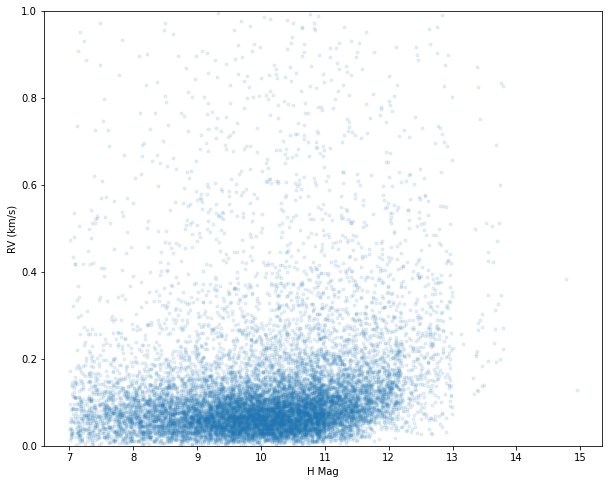

In [20]:
plt.figure(figsize=(10,8))
plt.plot(allStarGood_tab['hmag'],allStarGood_tab['vscatter'],'.',alpha=0.1)
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.ylim(0,1)
plt.show()

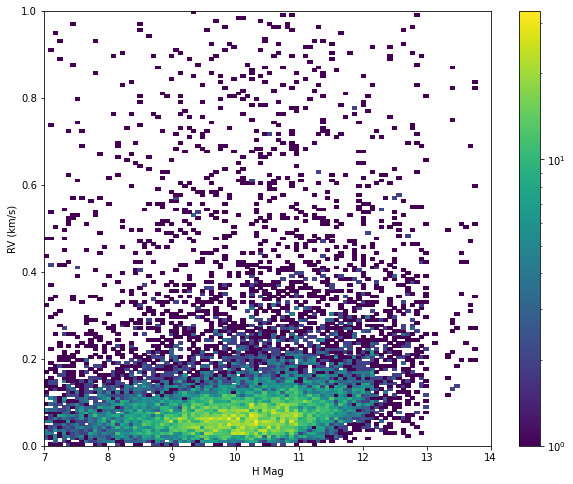

In [21]:
plt.figure(figsize=(10,8))
plt.hist2d(allStarGood_tab['hmag'],allStarGood_tab['vscatter'],bins=(100,150),range=((7,14),(0,1.0)),
           norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
#plt.yscale('log')
#plt.cscale('log')
plt.colorbar()
plt.show()

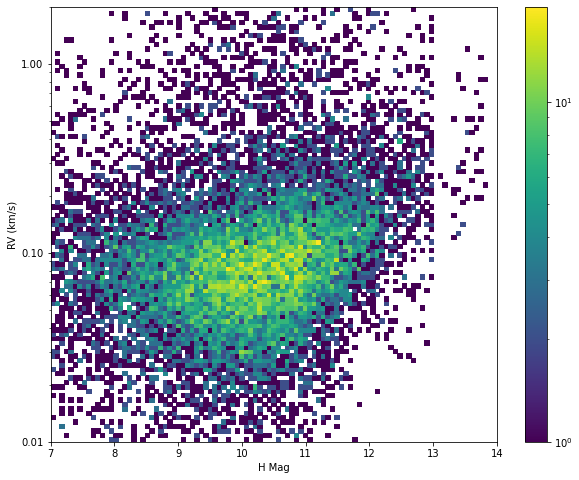

In [22]:
plt.figure(figsize=(10,8))
xbins = np.linspace(7, 14, 100)
ybins = 10**np.linspace(-2, .3, 100)
counts, _, _ = np.histogram2d(allStarGood_tab['hmag'],allStarGood_tab['vscatter'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,2)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

Zeropoint: 10.80 +/- 0.023


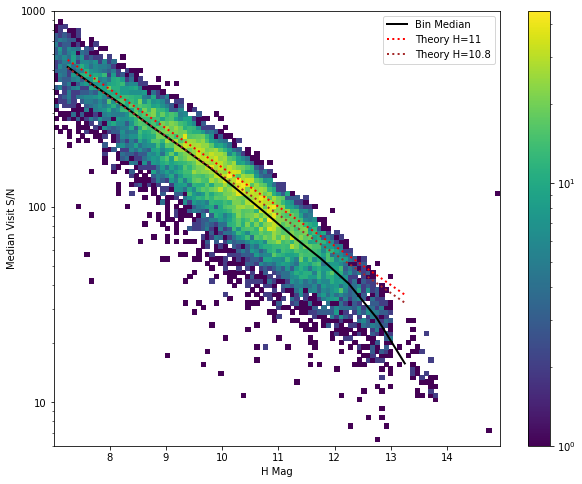

In [23]:
plt.figure(figsize=(10,8))
ybins = 10**np.linspace(np.log10(6), 3, 100)
plt.hist2d(allStarGood_tab['hmag'],allStarGood_tab['visit_med_snr'],bins=(100,ybins), \
           norm=mpl.colors.LogNorm())
xbins2 = np.linspace(7,13.5,14)
(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['hmag'],\
                                                            allStarGood_tab['visit_med_snr'], statistic='median', \
                                                            bins=xbins2)
xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
(param,cov) = curve_fit(fit_h2sn,xbinCen_arr,median_arr,p0=[11])
perr = np.sqrt(np.diag(cov))
print("Zeropoint: {:.2f} +/- {:.3f}".format(param[0],perr[0]))

plt.plot(xbinCen_arr,median_arr,lw=2,c='k', label="Bin Median")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=60),'r:',lw=2,label="Theory H=11")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=60,zeropoint=param[0]),':', c='brown',lw=2, \
         label="Theory H={:.1f}".format(param[0]))
plt.xlabel("H Mag")
plt.ylabel("Median Visit S/N")
plt.yscale('log')
plt.colorbar()
plt.legend()
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('Plate_Hvsn.png',dpi=200)
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]


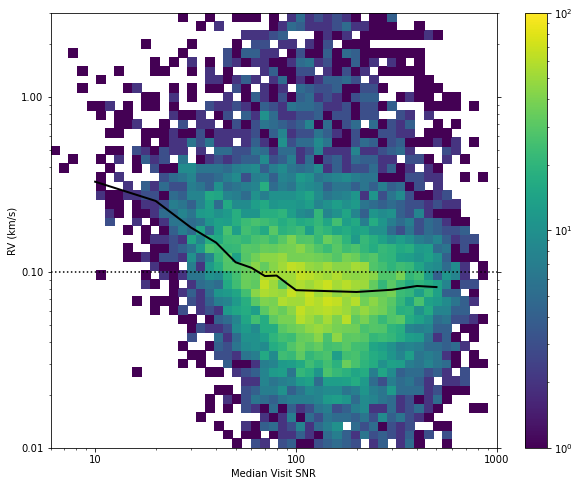

In [24]:
plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]
ybins = 10**np.linspace(-2,np.log10(3), 50)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['visit_med_snr'],allStarGood_tab['vscatter'], statistic='median', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)

counts, _, _ = np.histogram2d(allStarGood_tab['visit_med_snr'],allStarGood_tab['vscatter'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("RV (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

[ 109.  266.  457.  631.  734.  871.  906.  885.  804. 5829. 2292. 1001.
  495.  227.]


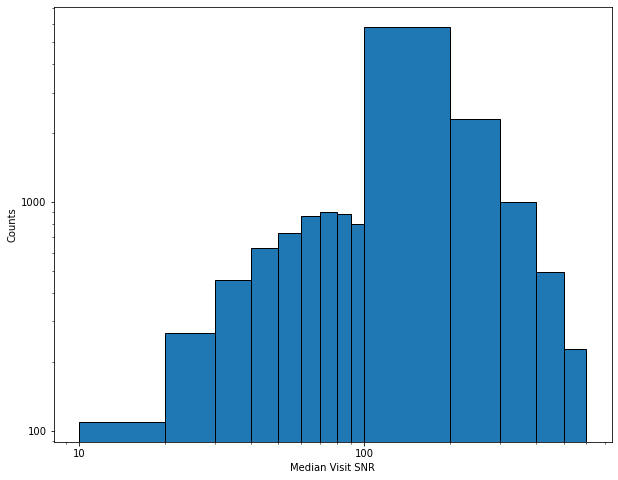

In [25]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(allStarGood_tab['visit_med_snr'],xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

In [26]:
plate_tab = Table()
plate_tab['Visit_SNR'] = xbinCen_arr
plate_tab['RV_all'] = median_arr
plate_tab.write('platefit_all.fits',overwrite=True)
plate_tab

Visit_SNR,RV_all
int64,float64
10,0.3278779685497284
20,0.25483328104019165
30,0.17962852120399475
40,0.14751432836055756
50,0.11401847004890442
60,0.10597917437553406
70,0.09513713419437408
80,0.09575290977954865
90,0.08635426312685013


## Reproduce David's plot
1. Dwarfs: log >= 4.1
2. Subgiants: 3.5 <= log g < 4.1 (or Teff >= 5000K and 3.0 <= log g <3.5)
3. Giants: log g <= 3.0 (or Teff < 5000 K and 3.0 <= log g < 3.5).

In [27]:
david_tab = allStarSmall_tab[(allStarSmall_tab['rv_logg'] < 3.0) & (allStarSmall_tab['mysnr']>= 20) & \
    (allStarSmall_tab['ngoodvisits'] >= 3)]

david_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32
15321,2M00371939-0028049,apStar-daily-apo25m-2M00371939-0028049-59187.fits,apogee/spectro/redux/daily/stars/apo25m/99/99085/apStar-daily-apo25m-2M00371939-0028049-59187.fits,59187,59168,59187,apo25m,daily,99085,0.0,9.3313652,-0.4681253,115.10789071998245,-63.12523602870772,12.564,0.024,12.319,0.023,12.298,0.024,,109.611,-26.128,,0,0,0,0,0,0,4374645457,2542941597844508800,1.41691,0.0277638,109.611,0.0634755,-26.1283,0.0348536,13.4678,0.000212,13.711,0.000914,13.0578,0.000664,0,ops_std_boss,,3,3,3,1048576,RV_SUSPECT,0,,-84.032936,3.2178261,1.8578128,0.46337083,1.3790739,4809.765,24.438816,2.8070805,0.060694158,-2.499999,0.028383037,nan,nan,1,223.0,0.0,2020-12-06 20:19:15.672362-07,29.1165,64.85181
15388,2M00390960-0026314,apStar-daily-apo25m-2M00390960-0026314-59187.fits,apogee/spectro/redux/daily/stars/apo25m/98/98574/apStar-daily-apo25m-2M00390960-0026314-59187.fits,59187,59168,59187,apo25m,daily,98574,0.0,9.7900344,-0.4420866,116.12297879406962,-63.151351469115504,10.394,0.022,9.878,0.022,9.81,0.019,,3.928,-2.824,,0,0,0,0,0,0,4374647409,2542955754056773376,0.347359,0.0480259,3.92767,0.0907392,-2.82429,0.0514502,11.9198,0.000375,12.4272,0.000715,11.2638,0.00056,8388608,mwm_tessrgb_core,MWM_TESSRGB,3,3,3,0,,0,,-125.14742,0.037638232,0.021730443,0.049926046,2.2458537,4824.2764,5.879551,2.4518363,0.015648812,-1.9509542,0.005760615,nan,nan,1,86.0,0.0,2020-12-06 20:34:34.545873-07,196.976,325.67737
15381,2M00395069-0006192,apStar-daily-apo25m-2M00395069-0006192-59187.fits,apogee/spectro/redux/daily/stars/apo25m/98/98574/apStar-daily-apo25m-2M00395069-0006192-59187.fits,59187,59168,59187,apo25m,daily,98574,0.0,9.9613088,-0.1053426,116.57384411704582,-62.833839249715815,8.085,0.021,7.416,0.026,7.232,0.017,,5.526,3.315,,0,0,0,0,0,0,4374648688,2542980974104761984,0.923142,0.0577935,5.52621,0.0895481,3.31508,0.0490137,10.0318,0.000302,10.7878,0.000844,9.21936,0.000499,8388608,mwm_tessrgb_core,MWM_TESSRGB,3,3,3,0,,0,,-0.3670154,0.054614186,0.031531516,0.031677112,29.68592,4304.548,5.2942452,2.1197093,0.018884217,-0.31154674,0.0070993486,nan,nan,1,202.0,0.0,2020-12-06 20:33:45.687895-07,734.306,1186.5192
15384,2M00392009-0103325,apStar-daily-apo25m-2M00392009-0103325-59187.fits,apogee/spectro/redux/daily/stars/apo25m/99/99598/apStar-daily-apo25m-2M00392009-0103325-59187.fits,59187,59168,59187,apo25m,daily,99598,0.0,9.8337266,-1.0591233,116.07395595678871,-63.76954600392122,9.273,0.023,8.635,0.024,8.57,0.019,,-8.127,-21.079,,0,0,0,0,0,0,4374643475,2542847074204298752,0.394946,0.0461089,-8.12661,0.111328,-21.0786,0.0474625,10.8912,0.000466,11.4808,0.000611,10.1876,0.000556,8388608,mwm_tessrgb_core,MWM_TESSRGB,3,3,3,2048,PERSIST_LOW,0,,-145.26495,0.09241995,0.0533586

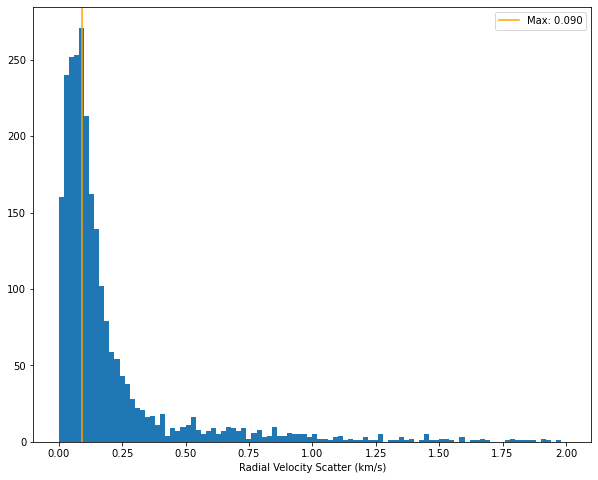

In [28]:
plt.figure(figsize=(10,8))
(counts,bins,patches) = plt.hist(david_tab['vscatter'],100,(0,2))
max_ind = np.argmax(counts)
max_cen = (bins[max_ind] + bins[max_ind+1]) /2
plt.gca().axvline(max_cen,c='orange',label='Max: {:0.3f}'.format(max_cen))
#plt.gca().axvline(0.1,c='k',label='0.1 km/s')
plt.xlabel("Radial Velocity Scatter (km/s)")
plt.legend()
plt.show()

In [29]:
david2_tab = allStarSmall_tab[(allStarSmall_tab['rv_teff'] > 4000) & (allStarSmall_tab['rv_teff'] < 4500)]
david2_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32
15344,2M00385895-0109389,apStar-daily-apo25m-2M00385895-0109389-59187.fits,apogee/spectro/redux/daily/stars/apo25m/100/100109/apStar-daily-apo25m-2M00385895-0109389-59187.fits,59187,59168,59187,apo25m,daily,100109,0.0,9.7456699,-1.1602982,115.8508418052636,-63.86061980477525,10.701,0.029,10.046,0.024,9.852,0.023,,3.872,109.434,,0,0,0,0,0,0,4374641567,2542470869429424512,12.4333,0.0387339,3.87191,0.0889659,109.434,0.0491157,13.0845,0.000408,14.1522,0.002353,12.0612,0.000823,128,mwm_snc_100pc,MWM_SNC_100PC,3,3,3,0,,0,,1.4031123,0.055888172,0.032267053,0.038230646,4.699733,4004.3416,3.0928776,4.99,0.008289083,-0.32222462,0.0053659673,nan,nan,1,58.0,0.0,2020-12-06 20:24:03.308721-07,226.509,365.47742
15381,2M00395069-0006192,apStar-daily-apo25m-2M00395069-0006192-59187.fits,apogee/spectro/redux/daily/stars/apo25m/98/98574/apStar-daily-apo25m-2M00395069-0006192-59187.fits,59187,59168,59187,apo25m,daily,98574,0.0,9.9613088,-0.1053426,116.57384411704582,-62.833839249715815,8.085,0.021,7.416,0.026,7.232,0.017,,5.526,3.315,,0,0,0,0,0,0,4374648688,2542980974104761984,0.923142,0.0577935,5.52621,0.0895481,3.31508,0.0490137,10.0318,0.000302,10.7878,0.000844,9.21936,0.000499,8388608,mwm_tessrgb_core,MWM_TESSRGB,3,3,3,0,,0,,-0.3670154,0.054614186,0.031531516,0.031677112,29.68592,4304.548,5.2942452,2.1197093,0.018884217,-0.31154674,0.0070993486,nan,nan,1,202.0,0.0,2020-12-06 20:33:45.687895-07,734.306,1186.5192
15354,2M00392293-0040490,apStar-daily-apo25m-2M00392293-0040490-59187.fits,apogee/spectro/redux/daily/stars/apo25m/99/99598/apStar-daily-apo25m-2M00392293-0040490-59187.fits,59187,59168,59187,apo25m,daily,99598,0.0,9.845857,-0.6805702,116.19073077313865,-63.3943782701429,10.367,0.027,9.718,0.022,9.512,0.023,,60.408,-64.583,,0,0,0,0,0,0,4374647094,2542878444645452288,12.7545,0.0438498,60.4082,0.0917742,-64.5834,0.0434029,12.5509,0.000262,13.5148,0.001408,11.5851,0.000617,128,mwm_snc_100pc,MWM_SNC_100PC,3,3,3,2048,PERSIST_LOW,0,,26.305555,0.07599669,0.043876708,0.043477636,2.5559769,4092.316,3.3034172,4.8939476,0.0082921395,-0.048718076,0.004643421,nan,nan,1,21.0,0.0,2020-12-06 20:27:11.671462-07,108.892,179.75119
12712,2M22172719+0108132,apStar-daily-apo25m-2M22172719+0108132-59169.fits,apogee/spectro/redux/daily/stars/apo25m/96/96475/apStar-daily-apo25m-2M22172719+0108132-59169.fits,59169,59167,59169,apo25m,daily,96475,0.0,334.3633,1.1369707,63.967414237356344,-43.42169237068328,10.246,0.027,9.479,0.026,9.297,0.023,,-9.052,-9.181,,0,0,0,0,0,0,4381163996,2679403115542744320,0.371827,0.0442477,-9.05203,0.0652051,-9.18087,0.0742015,12.177,0.000293,12.9355,0.002195,11.3486,0.000616,8388608,mwm_tessrgb_core,MWM_TESSRGB,3,3,3,0,,0,,-13.440863,0.025686042,0.014829843,

2357
[30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]
[108. 127. 144. 148. 125. 119. 113. 739. 272. 144.  98.]


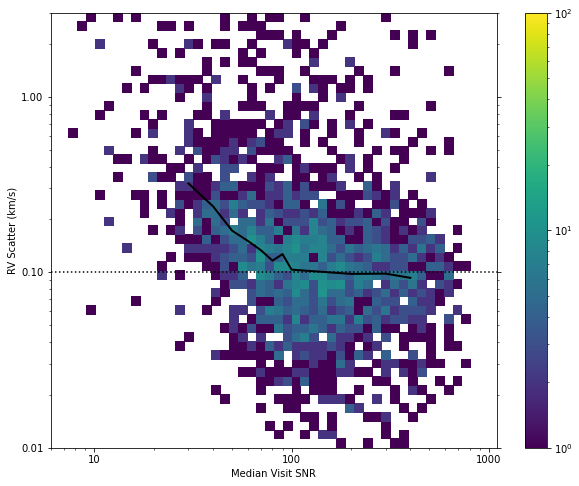

In [30]:
safe_snr_arr = david2_tab['visit_med_snr'][np.isfinite(david2_tab['visit_med_snr']) 
                                          & np.isfinite(david2_tab['vscatter'])] 
safe_rms_arr = david2_tab['vscatter'][np.isfinite(david2_tab['visit_med_snr']) 
                                          & np.isfinite(david2_tab['vscatter'])]
print(len(safe_snr_arr))

plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [30,40,50,60,70,80,90,100,200,300,400,500]
ybins = 10**np.linspace(-2,np.log10(3), 50)
xp = np.linspace(10,200)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='median', \
                       bins=xbins2)
(count_arr,_,_) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='count', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)
print(count_arr)

counts, _, _ = np.histogram2d(safe_snr_arr,safe_rms_arr,bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')

plt.xlabel("Median Visit SNR")
plt.ylabel("RV Scatter (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlim(6,1100)
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('Comm_3visit_RVs.png',dpi=200)
plt.show()

[108. 127. 144. 148. 125. 119. 113. 739. 272. 144.  98.]


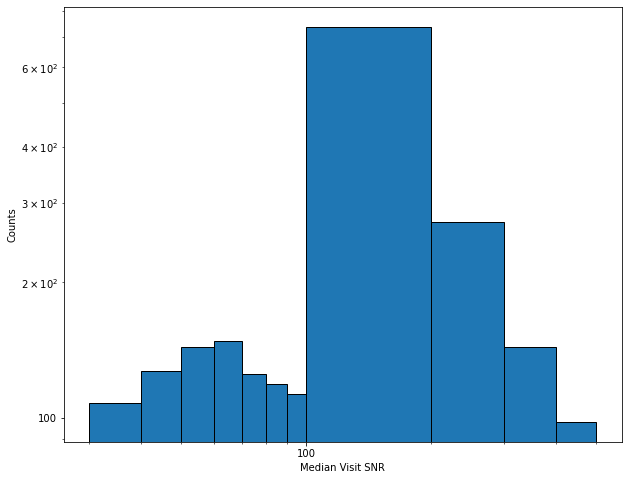

In [31]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(safe_snr_arr,xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

## Save Analysis Results

In [32]:
drplate_tab = Table()
drplate_tab['Visit_SNR'] = xbinCen_arr
drplate_tab['RV_david'] = median_arr
drplate_tab.write('platefit_david.fits',overwrite=True)
drplate_tab

Visit_SNR,RV_david
int64,float64
30,0.32049936056137085
40,0.23732416331768036
50,0.17225582897663116
60,0.15090110898017883
70,0.1332625448703766
80,0.11644681543111801
90,0.1267920732498169
100,0.10347111523151398
200,0.0978410467505455
